In [1]:
import os
import time
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from dask_ml.wrappers import ParallelPostFit  # wrapper so that model predicts using dask

from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

from joblib import dump

import model_prep_and_evals as mpe # custom module

In [2]:
# **************************************************************
# whole_set = True => merge train+test sets and train model with combined dataset
# whole_set = False => train model only with train set
whole_set = False

In [3]:
# ------------------------------
# Import train data

root = os.path.join(os.getcwd(), 'data_sampling_workflow')

# select features from red to avg_lidar
# excludes the following features: geometry, aoi, naip_id, polygon_id and iceplant 
X_train = pd.read_csv(os.path.join(root,
                                   'spectral_window_train_set.csv')).loc[:,'r':'avg_lidar']

# select iceplant feature column
y_train = pd.read_csv(os.path.join(root,
                                   'spectral_window_train_set.csv')).loc[:,'iceplant'] 

# remove 2012 and 2014 since these years do not have LIDAR data
X_train = X_train.loc[X_train.year != 2012]
X_train = X_train.loc[X_train.year != 2014]

y_train = y_train.iloc[X_train.index]

# ------------------------------
# Import test data

# select features from r (Red band) to avg_lidar // excludes geometry, aoi, naip_id, polygon)id and iceplant features
X_test = pd.read_csv(os.path.join(root,
                                  'spectral_window_test_set.csv')).loc[:,'r':'avg_lidar']

# select iceplant feature column
y_test = pd.read_csv(os.path.join(root,
                                  'spectral_window_test_set.csv')).loc[:,'iceplant'] 

# remove 2012 and 2014 since these years do not have LIDAR data
X_test = X_test.loc[X_test.year != 2012]
X_test = X_test.loc[X_test.year != 2014]

y_test = y_test.iloc[X_test.index]

# ------------------------------
if whole_set == True:
    X_train = pd.concat([X_train, X_test], axis = 0)
    y_train = pd.concat([y_train, y_test], axis = 0)


In [4]:
X_train.head()

,r,r_max,r_min,r_diff,r_avg,g,g_max,g_min,g_diff,g_avg,...,nir_avg,ndvi,year,month,day_in_year,lidar,max_lidar,min_lidar,min_max_diff,avg_lidar
0,107,113,105,8,22.444445,91,93,86,7,3.888889,...,2.333333,0.235714,2020,6,159,0.0,4.0,0.0,4.0,0.777778
1,123,127,113,14,5.555555,93,107,81,26,5.000000,...,14.666667,0.127660,2020,6,159,0.0,0.0,0.0,0.0,0.000000
2,109,109,103,6,21.333334,84,88,84,4,0.666667,...,28.222221,0.221429,2020,6,159,1.0,6.0,0.0,6.0,1.555556
3,92,94,87,7,5.333334,93,94,91,3,7.222222,...,8.666667,0.321033,2020,6,159,3.0,3.0,0.0,3.0,2.111111
4,83,83,79,4,24.888890,63,66,61,5,6.333334,...,25.111110,0.333333,2020,6,159,0.0,3.0,0.0,3.0,1.888889


In [5]:
# ------------------------------
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

In [6]:
rfc = ParallelPostFit(RandomForestClassifier(n_estimators = 100, 
                                             random_state = 42))
rfc.fit(X_train, y_train)
dump(rfc, 'lidar_spectral_rfc.joblib')

['lidar_spectral_rfc.joblib']

In [7]:
if whole_set == False:
    preds = rfc.predict(X_test.to_numpy())
    mpe.print_accuracy_info(y_test.to_numpy(), preds)

true negatives: 100696     false positives: 572
false negatives: 832     true positives: 54820

sensitivity (TP/P): 98.5 %
specificity (TN/N): 99.44 %
G-mean:  0.99

precision (TP/(TP+FP)): 98.97 %

MCC:  0.980439644919357

F1-measure:  0.98736
F0.5-measure (min false positives):  0.98875
F2-measure (min false negatives)  :  0.98597

accuracy: 99.11 %


In [8]:
result = permutation_importance(
    rfc, 
#    X_test.drop('avg_lidar',  axis = 1,inplace=True),
    X_test.to_numpy(),
    y_test.to_numpy(),
    n_repeats=10, 
    random_state=42, 
    n_jobs=2
)

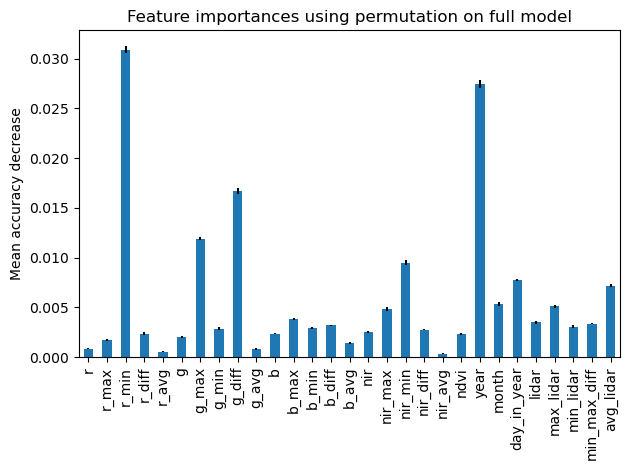

In [9]:
forest_importances = pd.Series(result.importances_mean, index=X_test.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

Note:
There are some points in the training and test set that have negative values for min_lidar. 
This is most likely points near the coast where the 3x3 window around the point includes no-data pixels in the canopy height raster.
No-data in the canopy height raster is represented by -999.
However, as a percentage of the points in the total training and test set, these are very few points:

0	275	(non-iceplant with negative min_lidar)
1	559	(iceplant with negative min_lidar)